<a href="https://colab.research.google.com/github/Txy822/Computer_vision/blob/main/OTweets_personality_type_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

**BERT**
Why BERT-Bidirectional Encoder Representations from Transformers (https://arxiv.org/pdf/1810.04805.pdf)

Reasearchers argue that current techniques restrict the
power of the pre-trained representations, espe-
cially for the fine-tuning approaches. The ma-
jor limitation is that standard language models are
unidirectional, and this limits the choice of archi-
tectures that can be used during pre-training.

Such re-strictions are sub-optimal for sentence-level tasks,
and could be very harmful when applying fine-
tuning based approaches to token-level tasks such
as question answering, where it is crucial to incor-
porate context from both directions. BERT alleviates the previously mentioned unidi-
rectionality constraint by using a “masked lan-
guage model” (MLM) pre-training objective. The
masked language model randomly masks some of
the tokens from the input, and the objective is to
predict the original vocabulary id of the masked
word based only on its context. Unlike left-to-
right language model pre-training, the MLM ob-
jective enables the representation to fuse the left
and the right context, which allows us to pre-
train a deep bidirectional Transformer. In addi-
tion to the masked language model, we also use
a “next sentence prediction” task that jointly pre-
trains text-pair representations.

BERT offers an advantage over models like Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them. For example, given two sentences:

“The man was accused of robbing a bank.” “The man went fishing by the bank of the river.”

Word2Vec would produce the same word embedding for the word “bank” in both sentences, while under BERT the word embedding for “bank” would be different for each sentence. Aside from capturing obvious differences like polysemy, the context-informed word embeddings capture other forms of information that result in more accurate feature representations, which in turn results in better model performance.

**Is removing stopwords necassary?**


With BERT you don't process the texts; otherwise, you lose the context (stemming, lemmatization) or change the texts outright (stop words removal).

Some more basic models (rule-based or bag-of-words) would benefit from some processing, but you must be very careful with stop words removal: many words that change the meaning of an entire sentence are stop words (not, no, never, unless).

You can test to see if doing stemming lemmatization and stopword removal helps. It doesn't always. I usually do if I gonna graph as the stopwords clutter up the results.

A case for not using Stopwords Using Stopwords will provide context to the user's intent, so when you use a contextual model like BERT. In such models like BERT, all stopwords are kept to provide enough context information like the negation words (not, nor, never) which are considered to be stopwords.

According to https://arxiv.org/pdf/1904.07531.pdf ,surprisingly, the stopwords received as much attention as non-stop words, but removing them has no effect inMRR performances.

**There are at least two reasons why BERT is a powerful language model:**
It is pre-trained on unlabeled data extracted from BooksCorpus, which has 800M words, and from Wikipedia, which has 2,500M words.
As the name suggests, it is pre-trained by utilizing the bidirectional nature of the encoder stacks. This means that BERT learns information from a sequence of words not only from left to right, but also from right to left.It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with [PAD] token. If the tokens in a sequence are longer than 512, then we need to do a truncation. And that’s all that BERT expects as input. BERT model then will output an embedding vector of size 768 in each of the tokens(if a sentence has 50 takens or words the full sentence has 50 vectors of each 768 size). We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.For a text classification task, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task. Below is the illustration of the input and output of the BERT model.


example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])
>>>tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
>>>tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
>>>tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])

1. The first row is input_ids , which is the id representation of each token. We can actually decode these input ids into the actual tokens as follows:
As you can see, the BertTokenizer takes care of all of the necessary transformations of the input text such that it’s ready to be used as an input for our BERT model. It adds [CLS], [SEP], and [PAD] tokens automatically. Since we specified the maximum length to be 10, then there are only two [PAD] tokens at the end.
2. The second row is token_type_ids , which is a binary mask that identifies in which sequence a token belongs. If we only have a single sequence, then all of the token type ids will be 0. For a text classification task, token_type_ids is an optional input for our BERT model.
3. The third row is attention_mask , which is a binary mask that identifies whether a token is a real word or just padding. If the token contains [CLS], [SEP], or any real word, then the mask would be 1. Meanwhile, if the token is just padding or [PAD], then the mask would be 0.
As you might notice, we use a pre-trained BertTokenizer from bert-base-cased model. This pre-trained tokenizer works well if the text in your dataset is in English. ref[ https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f ]

About idfTDF https://www.kdnuggets.com/2018/11/multi-class-text-classification-model-comparison-selection.html

personality classi https://www.kaggle.com/alfredmaboa/personality-profile-prediction-team-01

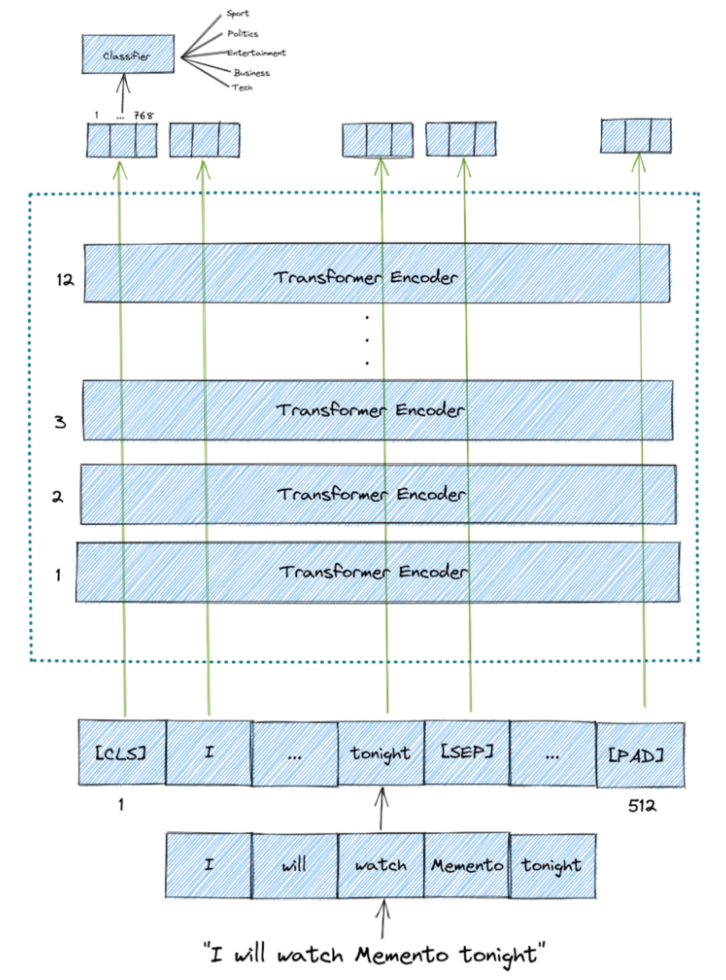

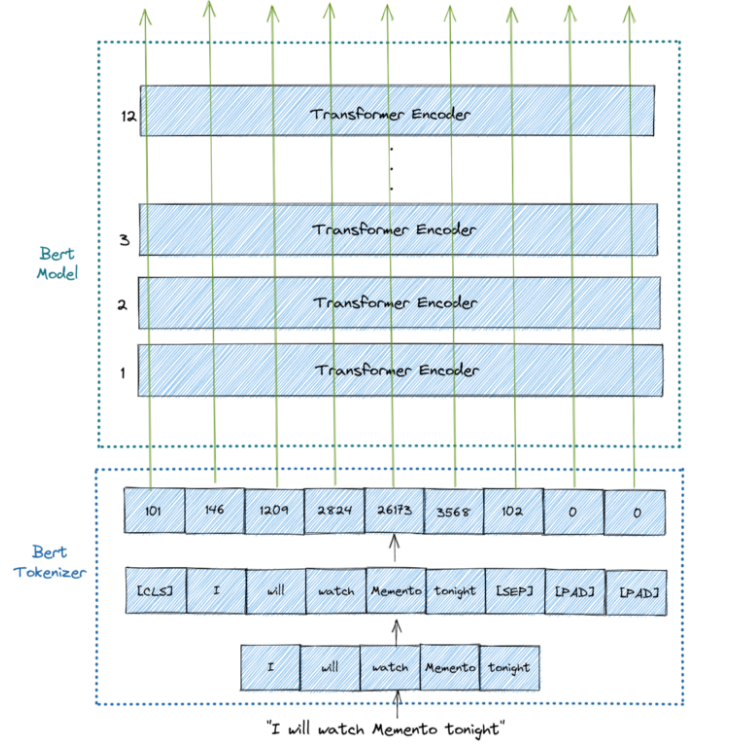

If incase necassary to reduce the personality type to 8 instead of 16 refer:[https://www.kaggle.com/prajwalkaushal/personality-prediction-mbti#Processing]

**(I) Set up device**

**Check if TPU is available**

In [ ]:
#Check if TPU is available
import tensorflow as tf
use_tpu = True
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Text augmentation

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

text = 'The quick brown fox jumps over the lazy dog .'
print(text)

In [ ]:
aug = naw.ContextualWordEmbsAug(
model_path='bert-base-uncased', action="insert")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Contents
1.  [3](https://colab.research.google.com/drive/1bvMU0-1jlQoRTbcAFqXcC7h38jeRiS_K?authuser=1#scrollTo=Ra3HjqUyx6Qj&line=1&uniqifier=1)

2. [4] (3)**bold text**


[Title of Subsection] (#shorthand_id)
                       
<a id='#shorthand_id'>Subsection Title</a>

# 2. Install and Import Libraries

**1. Install and Import Libraries**

In [ ]:
# install transformers
pip install transformers

Install  nlpaug for NLP augmentation

In [ ]:
# install  nlp augmentation
pip install nlpaug

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
import numpy as np
from numpy.random import RandomState
import pandas as pd
import os
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.get_logger().setLevel('ERROR')
# Data Analysis
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
# augmentation libraries

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

# Model training and evaluation
from sklearn.model_selection import train_test_split


from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import regex as re
from keras import backend as K
import plotly.express as px

#Metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import keras
import keras.utils
from keras import utils as utils

# word2vec 
import gensim.models 
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from gensim.models import Word2Vec
import nltk
# Cell
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as precision_recall_fscore_support

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO)

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# download nltk wordnet for finding sysnonym
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# for word2vec
nltk.download('punkt')

In [ ]:
nltk.download('stopwords')

**2. Load Data**



# 3. Load Data

For this project I am going to use real tweets data set which is available at : https://bitbucket.org/bplank/wassa2015/src/master/data/1000g.all .

In [ ]:
#mount google drive to fetch files
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# data path of the dataset
# data_path="/content/drive/MyDrive/datasets/twitter_personality_dataset/bplank-wassa2015_clean_tweets.csv"
data_path="/content/drive/MyDrive/datasets/twitter_personality_dataset/personality_from_tweets.csv"

In [ ]:
#separe csv with {{}} separatordata  and change to df
# dataset2 =  pd.read_csv(data_path2, sep='{{}}')
# #export df to csv 
# dataset2.to_csv('/content/drive/MyDrive/datasets/twitter_personality_dataset/personality_from_tweets.csv',index=False)
df=  pd.read_csv(data_path)


In [ ]:
# data_set shape and size
df.shape

(1500, 2)

**Visualize data distribution for each class type or personality type**

In [ ]:
df.head()

type                                              posts
0  ENFJ  \tf\t998\t@USER @USER @USER would be great or ...
1  ENFJ  \tf\t998\tsay what ? this weekend has been ful...
2  ENFJ  \tm\t1000\tdaaamn ru was so mad .... @URL / cv...
3  ENFJ  \tf\t999\tin all , i may have slept an uninter...
4  ENFJ  \tf\t100\tthat tumblr post comparing louis ' l...

In [ ]:
df.tail()

type                                              posts
1495  INTJ  \tf\t991\ti saw a fb comment based on this pos...
1496  INTJ  \tm\t1000\tsext : i shout , " pump up the jam ...
1497  ENFJ  \tm\t1000\t* sighs * i slept half of the day n...
1498  ENFJ  \tm\t1000\t@USER hahaha yesss ... and now begi...
1499  ENFJ  \tf\t1000\tvia @USER : fatal car wrecks increa...

Text(0.5, 1.0, 'Total posts for each personality type')

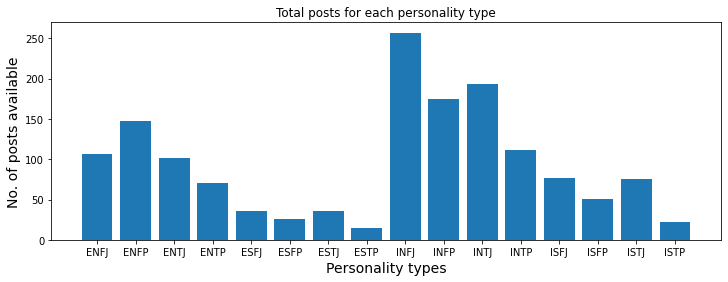

In [ ]:
""" This shows the distribution of the dataset for each class bar chart"""
total = df.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
#distribution in pie
px.pie(df,names='type',title='Distribution of personality types',hole=0.3)

Split dataset Temp

In [ ]:
np.random.seed(112)
train_data_set, val_data_set, test_data_set = np.split(data_set.sample(frac=1, random_state=42), 
                                     [int(.6*len(data_set)), int(.8*len(data_set))])

print(len(train_data_set),len(val_data_set), len(test_data_set))

900 300 300


In [ ]:
""" This shows the distribution of the dataset for each class bar chart"""
total = train_data_set.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
""" This shows the distribution of the dataset for each class bar chart"""
total = val_data_set.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
""" This shows the distribution of the dataset for each class bar chart"""
total = test_data_set.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
#  get length of all the messages in the train set
seq_len = [len(i.split()) for i in data_set.posts.values]

pd.Series(seq_len).hist(bins = 30)

# 4. Data processing

## 4.1 Data pre-processing

In [ ]:
#@title ### cleaning dataset
# clean data input, dataset, n for choping to 512 (BERT), vectorizer_type=countVec_tfidf,Word2vec,BERT
# vectorizer_type=["countVec_tfidf","word2vec","BERT"]
def pre_process_df(data, n, vectorizer_type):
    # processed_text=[]

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    empty_data = []
    df = pd.DataFrame(empty_data, columns = ['type', 'posts'])
    if(vectorizer_type=="BERT"):
      for sentence,p_type in zip(data.posts,data.type):
        sentence=sentence.lower()
        #removing links from text data

        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)

        #removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)

        # split sentence as word list
        word_list=sentence.split()
        # length of the word list
        length_word_list=len(word_list)
        # n is 512 for bert, the amount of sentences per 512 word
        number_of_sentences_of_n_words=int(length_word_list/n)
        # append each sentences to adatset  as new element of df 
        for i in range(lnumber_of_sentences_of_n_words):
          # start from i+i*n  
          fro_m=(i+i*n)    #0,   513,  1026 ...
          # to (i+1)*(n+1)
          to=((i+1)*(n+1)) #513, 1026, 1539 ...
          # join sentences from :to
          section=" ".join(word_list[fro_m:to])
          # section=" ".join(word_list[0:n-1])

          df = df.append({'type': p_type, 'posts': section}, ignore_index=True)
    else:
      for sentence,p_type in zip(data.posts,data.type):
        # HTML decoding
        sentence = BeautifulSoup(text, "lxml").text 
        # lowercase text
        sentence = text.lower() 
        # replace REPLACE_BY_SPACE_RE symbols by space in text
        sentence = REPLACE_BY_SPACE_RE.sub(' ', text) 
        # delete symbols which are in BAD_SYMBOLS_RE from text
        sentence = BAD_SYMBOLS_RE.sub('', text) 
         # delete stopwors from text
        sentence = ' '.join(word for word in sentence.split() if word not in STOPWORDS)
        # append all to dataset
        df = df.append({'type': p_type, 'posts': sentence}, ignore_index=True)
  
    return df

In [ ]:
#@title label encoding of dataset
# Converting MBTI personality type into numerical form using Label Encoding
# encoding personality type
enc = LabelEncoder()
df['type_encoding'] = enc.fit_transform(df['type'])

In [ ]:
#@title shuffling dataset
#shuffle dataset 
from sklearn.utils import shuffle
data_set = shuffle(df,random_state=1000)

In [ ]:
#@title process data
# way of vectorization as array
vectorizer_type=["countVec_tfidf","word2vec","BERT"]

# for the case of countVec_tfidf
processed_dataset_for_countVec_tfidf = pre_process_df(df,512,vectorizer_type[0])

# for the case of word2vec
processed_dataset_for_word2vec = ppre_process_df(df,512,vectorizer_type[1])

# for the case of BERT
processed_dataset_for_BERT = pre_process_df(df,512,vectorizer_type[2])

## 4.2 Save processed data

In [ ]:
# save the processed_dataset_for_countVec_tfidf dataset 
processed_dataset_for_countVec_tfidf.to_csv('tprocessed_dataset_for_countVec_tfidf.csv',index=False)

In [ ]:
# save the processed_dataset_for_word2vec dataset 
processed_dataset_for_word2vec.to_csv('processed_dataset_for_word2vec.csv',index=False)

In [ ]:
# save the pprocessed_dataset_for_BERT dataset 
processed_dataset_for_BERT.to_csv('processed_dataset_for_BERT.csv', index=False)

In [ ]:
train_df.to_csv('unaugmented_tweets_train_data_set.csv',index=False)
validation_df.to_csv('tweets_validation_data_set.csv',index=False)
test_df.to_csv('tweets_test_data_set.csv',index=False)

##4.3 Undersampling and oversampling without augmentation


As shown above fugures the  data set is imbalanced. Therefore, I use undersampling and oversampling technique to balance the dataset.

In [ ]:
#assign dataset class types for each 16
data_set_class_ENFJ = data_set[data_set['type'] == 'ENFJ'];data_set_class_ENFP = data_set[data_set['type'] == 'ENFP'];data_set_class_ENTJ = data_set[data_set['type'] == 'ENTJ'];data_set_class_ENTP = data_set[data_set['type'] == 'ENTP'];data_set_class_ESFJ = data_set[data_set['type'] == 'ESFJ'];data_set_class_ESFP = data_set[data_set['type'] == 'ESFP'];data_set_class_ESTJ = data_set[data_set['type'] == 'ESTJ'];data_set_class_ESTP = data_set[data_set['type'] == 'ESTP'];data_set_class_INFJ = data_set[data_set['type'] == 'INFJ'];data_set_class_INFP = data_set[data_set['type'] == 'INFP'];data_set_class_INTJ = data_set[data_set['type'] == 'INTJ'];data_set_class_INTP = data_set[data_set['type'] == 'INTP'];data_set_class_ISFJ = data_set[data_set['type'] == 'ISFJ'];data_set_class_ISTJ = data_set[data_set['type'] == 'ISTJ'];data_set_class_ISTP = data_set[data_set['type'] == 'ISTP'];data_set_class_ISFP = data_set[data_set['type'] == 'ISFP']

In [ ]:
#under sample and over sample the amout of types
amount=100
data_set_class_INFP_under=data_set_class_INFP.sample(amount);
data_set_class_INFJ_under = data_set_class_INFJ.sample(amount);
data_set_class_INTJ_under=data_set_class_INTJ.sample(amount);data_set_class_INTP_under = data_set_class_INTP.sample(amount);data_set_class_ENFJ_over=data_set_class_ENFJ.sample(amount);data_set_class_ENTJ_over = data_set_class_ENTJ.sample(amount);data_set_class_ESFJ_over=data_set_class_ESFJ.sample(amount,replace=True);data_set_class_ESFP_over = data_set_class_ESFP.sample(amount,replace=True);data_set_class_ESTJ_over=data_set_class_ESTJ.sample(amount,replace=True);data_set_class_ESTP_over = data_set_class_ESTP.sample(amount,replace=True);data_set_class_ISFJ_over=data_set_class_ISFJ.sample(amount,replace=True);data_set_class_ISFP_over = data_set_class_ISFP.sample(amount,replace=True);data_set_class_ISTJ_over=data_set_class_ISTJ.sample(amount,replace=True);data_set_class_ISTP_over = data_set_class_ISTP.sample(amount,replace=True)

In [ ]:
balanced_data_set= pd.concat([data_set_class_ENTP,data_set_class_ENFP,data_set_class_INFP_under, data_set_class_INFJ_under,data_set_class_INTJ_under,data_set_class_INTP,data_set_class_ENFJ_over,data_set_class_ENTJ_over,data_set_class_ESFJ_over,data_set_class_ESFP_over,data_set_class_ESTJ_over,data_set_class_ESTP_over,data_set_class_ISFJ_over,data_set_class_ISFP_over,data_set_class_ISTJ ,data_set_class_ISTP_over], axis=0)

In [ ]:
# balanced dataset shape
balanced_data_set.shape

(1604, 2)

In [ ]:
# for the time being the unbalanced dataset is used 
balanced_data_set=data_set

In [ ]:
""" This shows the distribution of the dataset for each class bar chart"""
total = balanced_data_set.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
#distribution in pie
px.pie(balanced_data_set,names='type',title='Distribution of personality types',hole=0.3)

In [ ]:
balanced_data_set.head()

type                                              posts
0  ENFJ  \tf\t998\t@USER @USER @USER would be great or ...
1  ENFJ  \tf\t998\tsay what ? this weekend has been ful...
2  ENFJ  \tm\t1000\tdaaamn ru was so mad .... @URL / cv...
3  ENFJ  \tf\t999\tin all , i may have slept an uninter...
4  ENFJ  \tf\t100\tthat tumblr post comparing louis ' l...

In [ ]:
#shuffle dataset 
from sklearn.utils import shuffle
balanced_data_set = shuffle(balanced_data_set,random_state=1000)

In [ ]:
# Converting MBTI personality type into numerical form using Label Encoding
# encoding personality type
enc = LabelEncoder()
balanced_data_set['type_encoding'] = enc.fit_transform(balanced_data_set['type'])

In [ ]:
# show sample post
balanced_data_set.posts.values[1]

'\tf\t998\tsay what ? this weekend has been full of surprises . like a package ! ahh ! imagine a new salty chocolate caramel pretzel treat and a double shot on ice at starbucks + car dancing with the suite mate ! top night ! :) something has gone horribly wrong when all of a sudden your coffee tastes like ... strawberries ? get ready @USER @URL / 9n8ayzf wishes there was an easy button so i can just redo this weekend . just witnessed an awkward hicky conversation . check . @HASHTAG double fistiny coffees . it\'s only noon time . it is one of those days . it is a monday . nothing takes you back to @HASHTAG like fold over pb & j and a glass of milk . gotta love old school sack lunches ! caught again . i have got to stop talking to myself ... i was studying ;) @USER you are the best study surprise ever ! midnight oil moments . blessings ! i think in blocks or in graphic design terms ... chunking . how gross of a term is that . it\'s times like these when i have to say ... i have a genius 

Text(0.5, 1.0, 'Total posts for each personality type')

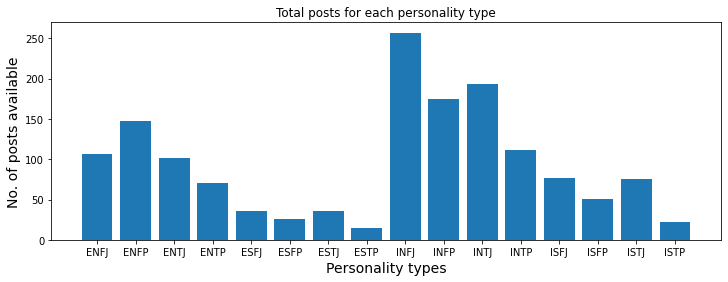

In [ ]:
""" This shows the distribution of the dataset for each class bar chart"""
total = balanced_data_set.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
balanced_data_set.head()

type                                              posts
886   INFP  \tf\t954\ti've seen c diff come out of an actu...
1042  INTJ  \tm\t916\tcheeky bit of " four seasons " by vi...
291   ENTJ  \tf\t979\tunfortunate that my first tweet ever...
1476  ISFJ  \tf\t999\thow to open up and be vulnerable @UR...
1024  INTJ  \tf\t626\tpre-dinner ... @URL / fd9mdnh065 btd...

**4.2 Data Augmentation and balancing dataset**

## 4.4 Split to train, val, and test dataset

#### 4.4.0 Augmentation

In [ ]:
# Training set needs to be augmented to some ecxtent to balance the data and increase the dataset. Ref:https://github.com/makcedward/nlpaug/blob/bb2fc63349bf949f6f6047ff447a0efb16983c0a/example/textual_augmenter.ipynb


#@title Augmentation  func 
def augment_dataset(df,n,type_list,pr=0.2):
    
    # aug_w2v.aug_p=pr
    # new_text=[]
    aug = naw.SynonymAug(aug_src='wordnet')
    for l in range(0, len(type_list)):
     
        pType=type_list[l]


        ##selecting the minority class samples
        df_n=df[df.type==pType].reset_index(drop=True)

        # type_encoding=df_n.type_encoding

        len_df_n=len(df_n)
        if(len_df_n>(2/3)*n):
            continue
        samples=n-len_df_n
        # print(len(df_n))
        if(samples>=len_df_n):
            k= (samples//len_df_n)
            for j in range(k):
                samples=len_df_n
                for i in tqdm(np.random.randint(0,len(df_n),samples)):
                    # for i in range(0,len(df_n)):
                    new_text=[]
                    text = df_n.iloc[i]['posts']

                    augmented_text1 =aug.augment(text)
                    augmented_text2 =aug.augment(augmented_text1)
                    augmented_text3 =aug.augment(augmented_text2)
                    augmented_text4 =aug.augment(augmented_text3)
                    augmented_text5 =aug.augment(augmented_text4)

                    new_text.append(augmented_text5)
                    
                    
                    ## dataframe
                    new=pd.DataFrame({'posts':new_text,'type':pType})
                    df=df.append(new)


        else:
            for i in tqdm(np.random.randint(0,len(df_n),samples)):
                # for i in range(0,len(df_n)):
            
                new_text=[]
                text = df_n.iloc[i]['posts']
            
                augmented_text1 =aug.augment(text)
                augmented_text2 =aug.augment(augmented_text1)
                augmented_text3 =aug.augment(augmented_text2)
                augmented_text4 =aug.augment(augmented_text3)
                augmented_text5 =aug.augment(augmented_text4)

                new_text.append(augmented_text5)
                
                
                ## dataframe
                new=pd.DataFrame({'posts':new_text,'type':pType})
                df=df.append(new)
        
    return df


#### 4.4.1  Dataset split for Counter

In [ ]:
#@title split code
np.random.seed(112)
train_data_set_countVec_tfidf, 
val_data_set_countVec_tfidf, 
test_data_set_countVec_tfidf = np.split(processed_dataset_for_countVec_tfidf.sample(frac=1, random_state=42), 
                            [int(.6*len(processed_dataset_for_countVec_tfidf)), 
                            int(.8*len(processed_dataset_for_countVec_tfidf))])

print(len(train_data_set_countVec_tfidf),
      len(val_data_set_countVec_tfidf), 
      len(test_data_set_countVec_tfidf))

In [ ]:
#@title aug_train_data_set_countVec_tfidf
type_list=["ISTJ","ISTP","ISFJ","ISFP","INFJ","INFP","INTJ","INTP","ESTP","ESTJ","ESFP","ESFJ","ENFP","ENFJ","ENTP","ENTJ"]
train_data_set_countVec_tfidf=augment_dataset(train_data_set_countVec_tfidf,150,type_list,0.2)

In [ ]:
#@title train_data_set_countVec_tfidf
""" This shows the distribution of the dataset for each class bar chart"""
total = train_data_set_countVec_tfidf.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
#@title val_data_set_countVec_tfidf
""" This shows the distribution of the dataset for each class bar chart"""
total = balanced_data_set.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
#@title test_data_set_countVec_tfidf
""" This shows the distribution of the dataset for each class bar chart"""
total = test_data_set_countVec_tfidf.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

#### 4.4.2 Dataset split for Word2vec 

In [ ]:
#@title split code
np.random.seed(112)
train_data_set_Word2vec, 
val_data_set_Word2vec, 
test_data_set_Word2vec.   = np.split(processed_dataset_for_word2vec.sample(frac=1, random_state=42),                                     
                         [int(.6*len(processed_dataset_for_word2vec)), 
                          int(.8*len(processed_dataset_for_word2vec))])

print(len(train_data_set_Word2vec),
      len(val_data_set_BERT), 
      len(test_data_set_Word2vec))

In [ ]:
#@title aug_train_data_set_Word2vec
type_list=["ISTJ","ISTP","ISFJ","ISFP","INFJ","INFP","INTJ","INTP","ESTP","ESTJ","ESFP","ESFJ","ENFP","ENFJ","ENTP","ENTJ"]
train_data_set_Word2vec=augment_dataset(train_data_set_Word2vec,150,type_list,0.2)

In [ ]:
#@title train_data_set_Word2vec distribution graph
""" This shows the distribution of the dataset for each class bar chart"""
total = train_data_set_Word2vec.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
#@title val_data_set_Word2vec distribution graph
""" This shows the distribution of the dataset for each class bar chart"""
total = val_data_set_Word2vec.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
#@title test_data_set_Word2vec  distribution graph
""" This shows the distribution of the dataset for each class bar chart"""
total = test_data_set_Word2vec.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

#### 4.4.3 Dataset split for BERT 

In [ ]:
#@title split code
np.random.seed(112)
train_data_set_BERT, 
val_data_set_BERT, 
test_data_set_BERT = np.split(processed_dataset_for_BERT.sample(frac=1, random_state=42),  
                  [int(.6*len(processed_dataset_for_BERT)), 
                  int(.8*len(processed_dataset_for_BERT))])

print(len(train_data_set_BERT),
      len(val_data_set_BERT), 
      len(test_data_set_BERT))

In [ ]:
#@title  aug_train_data_set_BERT
type_list=["ISTJ","ISTP","ISFJ","ISFP","INFJ","INFP","INTJ","INTP","ESTP","ESTJ","ESFP","ESFJ","ENFP","ENFJ","ENTP","ENTJ"]
train_data_set_BERT=augment_dataset(train_data_set_BERT,150,type_list,0.2)

In [ ]:
#@title show the words length  for a sentence 
#  get length of all the messages in the train set
seq_len = [len(i.split()) for i in balanced_data_set.posts.values]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
#@title train_data_set_BERT
""" This shows the distribution of the dataset for each class bar chart"""
total = train_data_set_BERT.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
#@title val_data_set_BERT
""" This shows the distribution of the dataset for each class bar chart"""
total = val_data_set_BERT.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

In [ ]:
#@title test_data_set_BERT
""" This shows the distribution of the dataset for each class bar chart"""
total = test_data_set_BERT.groupby(['type']).count()
plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

# 5 EXTRA2 

In [ ]:
#@title Default title text
#split to train, val and test
probs = np.random.rand(len(balanced_data_set))
training_mask = probs < 0.6
test_mask = (probs>=0.6) & (probs < 0.80)
validatoin_mask = probs >= 0.80


train_data_set = balanced_data_set[training_mask]
print("train data shape",train_data_set.shape)
test_data_set = balanced_data_set[test_mask]
print("testdata shape",test_data_set.shape)
validation_data_set = balanced_data_set[validatoin_mask]
print("validation data shape",validation_data_set.shape)

In [ ]:
def clean_text(text):
    """ clean the text by removing special characters, punctuations, etc. """
    text = text.lower()
    remove_xx_seq  = re.compile('xx+')
    replace_by_space = re.compile('[/(){}\[\]\|@,;]')
    remove_special_characters = re.compile('[^0-9a-z +]')
    remove_extra_space = re.compile('[^A-Za-z0-9]+')
    remove_numbers = re.compile('[0-9]+')
    text = re.sub(remove_xx_seq, ' ', text)
    text = re.sub(replace_by_space, ' ', text)
    text = re.sub(remove_special_characters, ' ', text)
    text = re.sub(remove_numbers, ' ', text)
    text = re.sub(remove_extra_space, ' ', text)
    return text.strip()

In [ ]:
ef preprocess_corpus(df, column='text'):
    """ Preprocess the entire corpus including cleaning the text documents and return the updated dataframe. """
    df[column] = df[column].apply(clean_text)
    return df

In [ ]:
def encode_labels(labels):
    """ Encode the class labels into a numbers. """
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    return label_encoder

In [ ]:
def compute_tfidf(corpus, stop_words='english', ngram_range=(1, 1), max_features=None):
    """ Calculate the tfidf features for all the text documents and return a (documents, fatures) matrix. """
    vectorizer = TfidfVectorizer(input='content', stop_words=stop_words, ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)
    print('Computing tfidf features...', end='')
    X = vectorizer.fit_transform(corpus)
    print('done!')
    return X, vectorizer

In [ ]:
def train_test_model(model, X_train, X_test, y_train, y_test,labels):
    """ Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports. """
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print('done!')
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    metrics_report = classification_report(y_test, predictions, target_names=labels)
    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, accuracy, metrics_report, (precision, recall, fscore)

In [ ]:
def pre_process_sentences(data):
    processed_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
        #removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
        #removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)

        processed_text.append(sentence)
    return processed_text

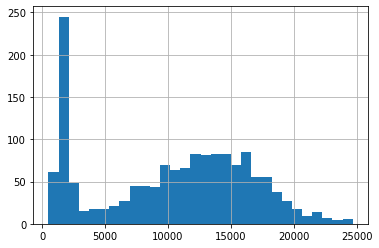

In [ ]:
# Create a dataframe that contain number of words for each document 
dlength_df = pd.DataFrame({'doc_length': data_set.posts.apply(lambda x: len(x.split()))})

# Group the documents based on their number of words (i.e. length)
grouped = dlength_df.groupby('doc_length')

indices = grouped.indices
word_count = []
doc_count = []
counter = 0
for w,d in indices.items():
    word_count.append(w)
    doc_count.append(len(d))

# Plot the distribution of words vs documents in the corpus
plt.figure(figsize=(8,5))
plt.plot(word_count, doc_count)
plt.xlabel('Word count in document')
plt.ylabel('Number of Documents')
plt.title('Word count vs Number of documents')

# Plot the Cumulative distribution of documents length
plt.figure(figsize=(8,5))
plt.hist(word_count, 30, density=True, histtype='step', cumulative=True, label='Complaints', color='red', linewidth=2)
plt.xlabel('Word count in document')
plt.ylabel('Fraction of Documents')
plt.legend(loc='upper left')
plt.title('Cumulative distribution of documents length')
plt.show()

In [ ]:
def augment_dataset(df,samples,pType,pr=0.2):
    # aug_w2v.aug_p=pr
    # new_text=[]
    aug = naw.SynonymAug(aug_src='wordnet')
    
    ##selecting the minority class samples
    df_n=df[df.type==pType].reset_index(drop=True)
    # type_encoding=df_n.type_encoding
 
    len_df_n=len(df_n)
    print(len(df_n))
    if(samples>=len_df_n):
      k= (samples//len_df_n)
      
      for j in range(k):
        samples=len_df_n
        for i in tqdm(np.random.randint(0,len(df_n),samples)):
      # for i in range(0,len(df_n)):
           
            new_text=[]
            text = df_n.iloc[i]['posts']
            type_encoding=df_n.iloc[i]['type_encoding']
            augmented_text1 =aug.augment(text)
            augmented_text2 =aug.augment(augmented_text1)
            augmented_text3 =aug.augment(augmented_text2)
            augmented_text4 =aug.augment(augmented_text3)
            augmented_text5 =aug.augment(augmented_text4)

            new_text.append(augmented_text5)
            
            
            ## dataframe
            new=pd.DataFrame({'posts':new_text,'type':pType,'type_encoding':type_encoding})
            df=shuffle(df.append(new).reset_index(drop=True))


    else:
      for z in tqdm(np.random.randint(0,len(df_n),samples)):
      # for i in range(0,len(df_n)):
           
            new_text=[]
            text = df_n.iloc[z]['posts']
            type_encoding=df_n.iloc[z]['type_encoding']
            augmented_text1 =aug.augment(text)
            augmented_text2 =aug.augment(augmented_text1)
            augmented_text3 =aug.augment(augmented_text2)
            augmented_text4 =aug.augment(augmented_text3)
            augmented_text5 =aug.augment(augmented_text4)

            new_text.append(augmented_text5)
            
            
            ## dataframe
            new=pd.DataFrame({'posts':new_text,'type':pType,'type_encoding':type_encoding})
            df=shuffle(df.append(new).reset_index(drop=True))

    ## data augmentation loop


    return df

# 6 Other classification models 

Build the Model
In this section, I will several different models for our multiclass classification task and compare them at the end. There are a wide variety of techniques that can be used. However, I decided to apply the following methods:

Naive Bayes (NB)

Logistic Regression

Linear SVM

Random Forest

XGBoosting

BERT

Naive Bayes Classifier

In [ ]:

nb_model = MultinomialNB()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, nb_prf = train_test_model(nb_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")
# plt.show()

Logistic Regression

In [ ]:
log_model = LogisticRegression(penalty='l2', max_iter=500)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, log_prf = train_test_model(log_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(log_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

SVM

In [ ]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, svm_prf = train_test_model(svm, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(svm, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, rf_prf = train_test_model(rf_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

Gradient Boosting

In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=50, max_depth=10)
predictions, accuracy, metrics_report, gb_prf = train_test_model(gb_model, X_train, X_test, y_train, y_test, labels)
print('accuracy: {}'.format(accuracy))
print(metrics_report)
plot_confusion_matrix(gb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

XGBClassifier Implementation for sklearn

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(objective='multi:softmax', n_estimators=100, learning_rate=0.3, max_depth=4, subsample=0.8, n_iter_no_change=2, verbosity=1)
xgb_param = xgb_model.get_xgb_params()
xgb_param['num_class'] = 7
cvresult = xgb.cv(xgb_param, xgb_train, num_boost_round=xgb_model.get_params()['n_estimators'], nfold=5, early_stopping_rounds=10, verbose_eval=True)
xgb.set_params(n_estimators=cvresult.shape[0])
predictions, accuracy, metrics_report = train_test_model(xgb_model, X_train, X_test, y_train, y_test)
print('accuracy: {}'.format(accuracy))
print(metrics_report)
plot_confusion_matrix(xgb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

XGB Implementation

In [ ]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
param['eta'] = 0.05
param['max_depth'] = 12
param['nthread'] = 4
param['num_class'] = 7
param['gpu_id'] = 0

watchlist = [(xgb_train, 'train'), (xgb_test, 'test')]
num_round = 5
bst = xgb.train(param, xgb_train, num_round)

bst = xgb.train(param, xgb_train, num_round, watchlist)
# get prediction
pred = bst.predict(xgb_test)
error_rate = np.sum(pred != y_test) / y_test.shape[0]
print('Test error using softmax = {}'.format(error_rate))

Performance Comparation

In [ ]:
xx = np.array([1,2,3])
width = 0.15
gb_prf = np.array([0.83, 0.83, 0.83])
ax = plt.subplot(111)
ax.bar( xx - width, height=np.array(nb_prf), width=width, color='b', align='center', label='NB', tick_label=['Precision', 'Recall', 'f1'])
ax.bar(xx ,height=np.array(log_prf), width=width, color='g', align='center', label='Log_Reg')
ax.bar(xx + width, height=np.array(svm_prf), width=width, color='r', align='center', label='SVM')
ax.bar(xx + 2*width, height=np.array(rf_prf), width=width, color='y', align='center', label='Random Forest')
ax.bar(xx + 3*width, height=np.array(gb_prf), width=width, color='black', align='center', label='Gradient Boosting')


plt.xlabel('Classification Metrics')
plt.ylabel('Scores')
plt.legend(loc='lower right')
plt.show()

Training Time Comparison
The plot below shows that Naive Bayes is incredibly fast and SVM is following it by having the 0.28s and 5.59s training times, respectively. I intentionally omitted Gradient boosting from the plot, because it has very large training time, to be able to have a better visualization.

In [ ]:
tr_times = [('NB', 0.28), ('Log_Reg', 111.02), ('SVM', 5.59), ('Random_Forest', 280.10)]
x_vals = []
h_vals = []
for t in tr_times:
    x_vals.append(t[0])
    h_vals.append(t[1])
    
ax = plt.subplot(111)
ax.bar(np.linspace(0,1,4) - width, height=np.array(h_vals), width=width, color='Green', tick_label=x_vals)
plt.xlabel('Techniques')
plt.ylabel('Training Time')
plt.show()

BERT IMPLEMENTATION

In [ ]:
from transformers import BertTokenizer, RobertaTokenizer
from transformers import TFBertModel, TFBertPreTrainedModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample

def convert_data_into_input_example(x, y):
    input_examples = []
    for i in tqdm(range(len(x))):
        example = InputExample(
            guid= None,
            text_a= x[i],
            text_b= None,
            label= str(y[i])
        )
        input_examples.append(example)
    return input_examples

def bert_compatiable_format(bdset):  
    input_ids, attention_mask, token_type_ids, labels = [], [], [], []
    for in_ex in bdset:
        input_ids.append(in_ex.input_ids)
        attention_mask.append(in_ex.attention_mask)
        token_type_ids.append(in_ex.token_type_ids)
        labels.append(in_ex.label)

    labels = np.vstack(labels)
    return ([np.asarray(input_ids), np.asarray(attention_mask), np.asarray(token_type_ids)], labels)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=False)
train_input_examples = convert_data_into_input_example(X_train, y_train)
val_input_examples = convert_data_into_input_example(X_test, y_test)


label_list = label_encoder.transform(labels)
label_list = [str(i) for i in label_list.tolist()]
bert_train_dataset = glue_convert_examples_to_features(examples=train_input_examples, tokenizer=tokenizer, max_length=128, task='mrpc', label_list=label_list)
bert_val_dataset = glue_convert_examples_to_features(examples=val_input_examples, tokenizer=tokenizer, max_length=128, task='mrpc', label_list=label_list)

x_train, y_train = bert_compatiable_format(bert_train_dataset)
x_val, y_val     = bert_compatiable_format(bert_val_dataset)

def example_to_features(input_ids, attention_masks, token_type_ids, y):
    return {"input_ids": input_ids,
            "attention_mask": attention_masks,
            "token_type_ids": token_type_ids},y


train_ds = tf.data.Dataset.from_tensor_slices((x_train[0], x_train[1], x_train[2], y_train)).map(example_to_features).shuffle(100).batch(64)
val_ds   = tf.data.Dataset.from_tensor_slices((x_val[0], x_val[1], x_val[2], y_val)).map(example_to_features).batch(64)
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
EPOCHS = 3

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

**Tokenization using pre trained tokenizer and model**

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# 6(1)  word2vec

In [ ]:
#@title load goolge w2v

google_news_vec_data_path="/content/drive/MyDrive/Datasets/GoogleNews-vectors-negative300.bin.gz"

wv = gensim.models.KeyedVectors.load_word2vec_format(google_news_vec_data_path, binary=True)
wv.init_sims(replace=True)
type_list=["ISTJ"," ISTP","ISFJ","ISFP","INFJ","INFP","INTJ","INTP","ESTP","ESTJ","ESFP","ESFJ","ENFP","ENFJ","ENTP","ENTJ"]

In [ ]:
#@title func word averaging
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [ ]:
#@title func w2v_tokenize_text
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
# train, test = train_test_split(dataset3, test_size=0.3, random_state = 42) 
# train, test = train_test_split(train_data_set_new, test_size=0.3, random_state = 42)
train, test = train_test_split(df, test_size=0.3, random_state = 42) #using df at bottom which stop words are removed

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['posts']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['posts']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [ ]:
#@title train by log_reg

logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['type'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.type))
print(classification_report(test.type, y_pred,target_names=my_tags))

In [ ]:
#@title evaluate
ConfusionMatrixDisplay.from_predictions(test.type, y_pred)

# 6(2) Multinomial NB

In [ ]:
#@title Optional data split
# optional
X = df.posts
y = df.type
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [ ]:
#@title Train NB
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

In [ ]:
#@title Evaluate
ConfusionMatrixDisplay.from_predictions(test.type, y_pred)

# 6(3) SVM SGDC classifier stochastic gradient descent 

In [ ]:
#@title SGDC train
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)


y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

In [ ]:
#@title Evaluate
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

#  6(4) Logistic regression

In [ ]:
#@title train LR
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

In [ ]:
#@title Evaluate
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# 7 Some background about BERT



*About Input IDs*

The input ids are often the only required parameters to be passed to the model as input. They are token indices, numerical representations of tokens building the sequences that will be used as input by the model.

Each tokenizer works differently but the underlying mechanism remains the same. Here’s an example using the BERT tokenizer, which is a WordPiece tokenizer: The tokenizer takes care of splitting the sequence into tokens available in the tokenizer vocabulary.For example

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

sequence = "A Titan RTX has 24GB of VRAM"


In [ ]:
# Continuation of the previous script
tokenized_sequence = tokenizer.tokenize(sequence)
tokenized_sequence 

['A',
 'Titan',
 'R',
 '##T',
 '##X',
 'has',
 '24',
 '##GB',
 'of',
 'V',
 '##RA',
 '##M']

These tokens can then be converted into IDs which are understandable by the model. Several methods are available for this, the recommended being encode or encode_plus, which leverage the Rust implementation of huggingface/tokenizers for peak performance.

In [ ]:
encoded_sequence = tokenizer.encode(sequence)
encoded_sequence 


[101,
 138,
 18696,
 155,
 1942,
 3190,
 1144,
 1572,
 13745,
 1104,
 159,
 9664,
 2107,
 102]

We can also use encode_plus as follows

In [ ]:
encoded_plus_sequence = tokenizer.encode_plus(sequence)
encoded_plus_sequence

{'input_ids': [101, 138, 18696, 155, 1942, 3190, 1144, 1572, 13745, 1104, 159, 9664, 2107, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

The encode and encode_plus methods automatically add “special tokens” which are special IDs the model uses.

**Attention  Mask**

The attention mask is an optional argument used when batching sequences together. This argument indicates to the model which tokens should be attended to, and which should not.

For example, consider these two sequences:

In [ ]:
sequence_a = "This is a short sequence."
sequence_b = "This is a rather long sequence. It is at least longer than the sequence A."

encoded_sequence_a = tokenizer.encode(sequence_a)
len(encoded_sequence_a)



8

In [ ]:
encoded_sequence_b = tokenizer.encode(sequence_b)
len(encoded_sequence_b)

19

These two sequences have different lengths and therefore can’t be put together in a same tensor as-is. The first sequence needs to be padded up to the length of the second one, or the second one needs to be truncated down to the length of the first one.

In the first case, the list of IDs will be extended by the padding indices:

In [ ]:
padded_sequence_a = tokenizer.encode(sequence_a, max_length=19, pad_to_max_length=True)

print("------------------------------------------------------------------------------------------------------------")
print(padded_sequence_a)
print("------------------------------------------------------------------------------------------------------------")
print(encoded_sequence_b)
print("------------------------------------------------------------------------------------------------------------")

------------------------------------------------------------------------------------------------------------
[101, 1188, 1110, 170, 1603, 4954, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------------------------------------------------------------------------------------------------------
[101, 1188, 1110, 170, 1897, 1263, 4954, 119, 1135, 1110, 1120, 1655, 2039, 1190, 1103, 4954, 138, 119, 102]
------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoded_sequence_b

These can then be converted into a tensor in PyTorch or TensorFlow. The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicate a value that should be attended to while 0 indicate a padded value.

The method encode_plus() may be used to obtain the attention mask directly:

In [ ]:
sequence_a_dict = tokenizer.encode_plus(sequence_a, max_length=19, pad_to_max_length=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
sequence_a_dict['input_ids']

[101, 1188, 1110, 170, 1603, 4954, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
sequence_a_dict['attention_mask']

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:

assert sequence_a_dict['input_ids'] == [101, 1188, 1110, 170, 1603, 4954, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
assert sequence_a_dict['attention_mask'] == [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

**Encoding the raw text**

Tokenization is a process to take raw texts and split into tokens, which are numeric data to represent words.

Official BERT language models are pre-trained with WordPiece vocabulary and use, not just token embeddings, but also segment embeddings distinguish between sequences, which are in pairs, e.g. question answering examples. Position embeddings are needed in order to inject positional awareness into the BERT model as the attention mechanism does not consider positions in context evaluation.

The important limitation of BERT to be aware of is that the maximum length of the sequence for BERT is 512 tokens. For shorter sequence input than the maximum allowed input size, we would need to add pad tokens [PAD]. On the other hand, if the sequence is longer, we need to cut the sequence. This BERT limitation on the maximum length of the sequence is something that you need to be aware of for longer text segments.

Very important are also the so-called special tokens, e.g. [CLS] token and [SEP] tokens. The [CLS] token will be inserted at the beginning of the sequence, the [SEP] token is at the end. If we deal with sequence pairs we will add additional [SEP] token at the end of the last.

**Token Type IDs**

Some models’ purpose is to do sequence classification or question answering. These require two different sequences to be encoded in the same input IDs. They are usually separated by special tokens, such as the classifier and separator tokens. For example, the BERT model builds its two sequence input as such:



In [ ]:
# [CLS] SEQ_A [SEP] SEQ_B [SEP]

sequence_a = "HuggingFace is based in NYC"
sequence_b = "Where is HuggingFace based?"

encoded_sequence = tokenizer.encode(sequence_a, sequence_b)
assert tokenizer.decode(encoded_sequence) == "[CLS] HuggingFace is based in NYC [SEP] Where is HuggingFace based? [SEP]"

This is enough for some models to understand where one sequence ends and where another begins. However, other models such as BERT have an additional mechanism, which are the segment IDs. The Token Type IDs are a binary mask identifying the different sequences in the model.

We can leverage encode_plus() to output the Token Type IDs for us:

In [ ]:
# Continuation of the previous script
encoded_dict = tokenizer.encode_plus(sequence_a, sequence_b)

assert encoded_dict['input_ids'] == [101, 20164, 10932, 2271, 7954, 1110, 1359, 1107, 17520, 102, 2777, 1110, 20164, 10932, 2271, 7954, 1359, 136, 102]
assert encoded_dict['token_type_ids'] == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

The first sequence, the “context” used for the question, has all its tokens represented by 0, whereas the question has all its tokens represented by 1. Some models, like XLNetModel use an additional token represented by a 2.

*Position IDs*

The position IDs are used by the model to identify which token is at which position. Contrary to RNNs that have the position of each token embedded within them, transformers are unaware of the position of each token. The position IDs are created for this purpose.

They are an optional parameter. If no position IDs are passed to the model, they are automatically created as absolute positional embeddings.

Absolute positional embeddings are selected in the range [0, config.max_position_embeddings - 1]. Some models use other types of positional embeddings, such as sinusoidal position embeddings or relative position embeddings.


## 7.1 extra Note one Train test val split for data set

The science behind dataset split ratio
Often it is asked in what proportion to split your dataset into Train, Validation, and Test sets?
This decision mainly depends on two things. First, the total number of samples in your data, and second, on the actual model you are training.
Some models need substantial data to train upon, so you would optimize for the more extensive training sets in this case.
Models with very few hyper-parameters will be easy to validate and tune, so you can probably reduce the size of your validation set.
But if your model has many hyper-parameters, you would want to have a significant validation set as well.
If you happen to have a model with no hyper-parameters or ones that cannot be easily tuned, you probably don’t need a validation set too.

In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv', parse_dates=['saledate'], low_memory=False)

from sklearn.model_selection import train_test_split

# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8

X = df.drop(columns = ['SalePrice']).copy()
y = df['SalePrice']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv', parse_dates=['saledate'], low_memory=False)


from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'SalePrice', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

In [ ]:
df = pd.read_csv('/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv', parse_dates=['saledate'], low_memory=False)


from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'SalePrice', 
                                                                            method='sorted', sort_by_col='saledate',
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

In [ ]:
# train_labels = tf.keras.utils.to_categorical(train_data_set.type_encoding.values, num_classes=16,dtype='float64')
train_labels = tf.keras.utils.to_categorical(train_data_set_new.type_encoding.values, num_classes=16,dtype='float64')

In [ ]:
validation_labels = tf.keras.utils.to_categorical(validation_data_set.type_encoding.values, num_classes=16)

In [ ]:
test_labels = tf.keras.utils.to_categorical(test_data_set.type_encoding.values, num_classes=16)


In [ ]:
train_labels.shape

(26037, 16)

In [ ]:
validation_labels.shape

(5095, 16)

In [ ]:
test_labels.shape

(4984, 16)

In [ ]:
# input dataset for inpu_ids, attention mask and labels of dataset
balanced_data_set_slices=tf.data.Dataset.from_tensor_slices((balanced_data_input_ids,balanced_data_attention_masks,new_labels))

In [ ]:

train_data_set_slices=tf.data.Dataset.from_tensor_slices((train_input_ids,train_attention_masks,train_labels))

In [ ]:

validation_data_set_slices=tf.data.Dataset.from_tensor_slices((validation_input_ids,validation_attention_masks,validation_labels))

In [ ]:

test_data_set_slices=tf.data.Dataset.from_tensor_slices((test_input_ids,test_attention_masks,test_labels))

In [ ]:
#mapping function to dict input ids ,attention mask and labels
def map_func(input_ids, masks, labels):
  return { 'input_ids':input_ids,'attention_mask':masks},labels

In [ ]:
#map all three(input_ids, attention mask, labels)
balanced_data_set_maped=balanced_data_set_slices.map(map_func)

In [ ]:
train_data_set_maped=train_data_set_slices.map(map_func)

In [ ]:
validation_data_set_maped=validation_data_set_slices.map(map_func)

In [ ]:
test_data_set_maped=test_data_set_slices.map(map_func)

In [ ]:
 #total number of trainable samples 
 num_samples=len(balanced_data_set)

In [ ]:
num_samples

25048

In [ ]:
batch_size=12

In [ ]:
#shuffle dataset with some batch
balanced_shuffled=balanced_data_set_maped.shuffle(1).batch(batch_size,drop_remainder=True)

In [ ]:
#shuffle dataset with some batch
train_ds=train_data_set_maped.shuffle(1).batch(batch_size,drop_remainder=True)

In [ ]:
#shuffle dataset with some batch

val_ds=validation_data_set_maped.shuffle(1).batch(batch_size,drop_remainder=True)

In [ ]:
#shuffle dataset with some batch
test_ds=test_data_set_maped.shuffle(1).batch(batch_size,drop_remainder=True)

In [ ]:
#total size of batched sample
total_len=int(num_samples/batch_size)

In [ ]:
total_len

2091

In [ ]:
#train_val_split spliting percentage
train_val_split=0.8

In [ ]:
#0.8 of total batched data
train_val_size=int(total_len*train_val_split)
train_val_size

1672

In [ ]:
#take the first 80% of total data set as temp_train_val dataset
temp_train_val_ds=balanced_shuffled.take(train_val_size)

In [ ]:
#take 80% as train size
train_size=int(train_val_size*train_val_split)

In [ ]:
train_size

1337

In [ ]:
#take 80% as of temp_train_val_dataset as train_ds
train_ds=temp_train_val_ds.take(train_size)

In [ ]:
#take the rest of temp_train_val_ds as validation ds
val_ds=temp_train_val_ds.skip(train_size)

In [ ]:
# validation size 
val_ds_size=train_val_size-train_size

In [ ]:
val_ds_size

335

In [ ]:
list(train_ds.as_numpy_iterator())[100]

In [ ]:
list(val_ds.as_numpy_iterator())[100]

In [ ]:
list(test_ds.as_numpy_iterator())[100]

In [ ]:
#take 20% of the whole batched dataset as test_ds
test_ds=balanced_shuffled.skip(train_val_size)

In [ ]:
test_size=total_len-train_val_size

In [ ]:
test_size

419

In [ ]:
list(test_ds.as_numpy_iterator())[0]

# 8 Bert toknization and embedding

In [ ]:
#@title Initialize bert toknizer
#Initialize Bert tokenizer
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# maximum length of asentence
# MAX_LEN = 1800
MAX_LEN = 512

In [ ]:
#@title func_tokenize sentences
#tokenize each sentences 
def tokenize_input_sentences(input_sentences, tokenizer, max_seq_len = MAX_LEN):
    tokenized_sentences = []

    for sentence in tqdm(input_sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                 # Sentence to encode.
                            truncation=True,           #truncates longer sentences     
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)
        
    return tokenized_sentences

In [ ]:
#@title func_create attention masks
#create attention masks for each input sentences
def attention_masks(tokenized_sentences):
    attention_masks = []

    for sentence in tokenized_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

In [ ]:
#@title func_input_ids&input_attention_masks
def input_data_pipline(data,tokenizer,max_length):
  #input ids, attention mask for each training, validation and test data
  in_ids = tokenize_input_sentences(data['posts'], tokenizer, max_length)
  input_ids = pad_sequences(in_ids, maxlen=max_length, dtype="long", value=0, truncating="post", padding="post")
  input_attention_masks = attention_masks(input_ids)
  return input_ids, input_attention_masks



In [ ]:
# #input ids and attention mask for all balanced data
# balanced_data_input_ids, balanced_data_attention_masks=input_data_pipline(balanced_data_set,tokenizer=tokenizer,max_length=MAX_LEN)

#@title train_input_ids, train_attention_masks
train_input_ids, train_attention_masks=input_data_pipline(train_data_set_new,tokenizer=tokenizer,max_length=MAX_LEN)

In [ ]:
#@title validation_input_ids, validation_attention_masks
validation_input_ids, validation_attention_masks=input_data_pipline(validation_data_set,tokenizer=tokenizer,max_length=MAX_LEN)

In [ ]:
#@title test_input_ids, test_attention_masks
test_input_ids, test_attention_masks=input_data_pipline(test_data_set,tokenizer=tokenizer,max_length=MAX_LEN)

In [ ]:
#add catagorical label for each class type for balanced data
new_labels=tf.keras.utils.to_categorical(balanced_data_set.type_encoding.values, num_classes=16,dtype='float64')
new_labels

## 8.1  Dataset Loader

In [ ]:
#@title Type labeling as categorical one hote encoding
# train_labels = tf.keras.utils.to_categorical(train_data_set.type_encoding.values, num_classes=16,dtype='float64')
train_labels = tf.keras.utils.to_categorical(train_data_set_new.type_encoding.values, num_classes=16,dtype='float64')

validation_labels = tf.keras.utils.to_categorical(validation_data_set.type_encoding.values, num_classes=16)

test_labels = tf.keras.utils.to_categorical(test_data_set.type_encoding.values, num_classes=16)

In [ ]:
#@title Data loader slicing

train_data_set_slices=tf.data.Dataset.from_tensor_slices((train_input_ids,train_attention_masks,train_labels))

validation_data_set_slices=tf.data.Dataset.from_tensor_slices((validation_input_ids,validation_attention_masks,validation_labels))

test_data_set_slices=tf.data.Dataset.from_tensor_slices((test_input_ids,test_attention_masks,test_labels))

In [ ]:
#@title map label, input_ids and mask
#mapping function to dict input ids ,attention mask and labels
def map_func(input_ids, masks, labels):
  return { 'input_ids':input_ids,'attention_mask':masks},labels

  train_data_set_maped=train_data_set_slices.map(map_func)

  validation_data_set_maped=validation_data_set_slices.map(map_func)

  test_data_set_maped=test_data_set_slices.map(map_func)

In [ ]:
#@title batch data and shuffle
batch_size=12
#shuffle dataset with some batch
train_ds=train_data_set_maped.shuffle(1).batch(batch_size,drop_remainder=True)

#shuffle dataset with some batch
val_ds=validation_data_set_maped.shuffle(1).batch(batch_size,drop_remainder=True)

#shuffle dataset with some batch
test_ds=test_data_set_maped.shuffle(1).batch(batch_size,drop_remainder=True)

# 10 Model set up

In [ ]:
#import prretrained model
from transformers import TFAutoModel
# transformers=TFAutoModel.from_pretrained('bert-base-cased')
# transformers.summary()


In [ ]:
#Define f1 functions for evaluation
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
pretrained_bert_model=TFAutoModel.from_pretrained('bert-base-cased')


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
pretrained_bert_model.summary()

Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def classifier_model():
  input_ids=tf.keras.layers.Input(shape=(MAX_LEN,),name='input_ids', dtype='int32')
  masks=tf.keras.layers.Input(shape=(MAX_LEN,),name='attention_mask', dtype='int32')
  
  bert_output=pretrained_bert_model.bert(input_ids,masks)[1] # this output has 3 dimension, [0], 3D tensor pooled to 2D tensor so take pooled layer, [1] pool is done

  net = tf.keras.layers.Dense(1024, activation='relu')(bert_output)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(128, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  out = tf.keras.layers.Dense(16, activation='softmax',name='outputs')(net)
  model=tf.keras.Model(inputs=[input_ids, masks],outputs=out)
  model.layers[2].trainable=True #freezs bert layer parameter for computational cost

  # #convert this embeddings to label prediction by adding linear classifier which is trained from scratch
  # x=tf.keras.layers.Dense(1024,activation='relu')(bert_output)
  # y=tf.keras.layers.Dense(16,activation='softmax',name='outputs')(x)
  # model=tf.keras.Model(inputs=[input_ids, masks],outputs=y)
  # # model.layers[2].trainable=True #freezs bert layer parameter for computational cost
  return model


# 11  Note about loss

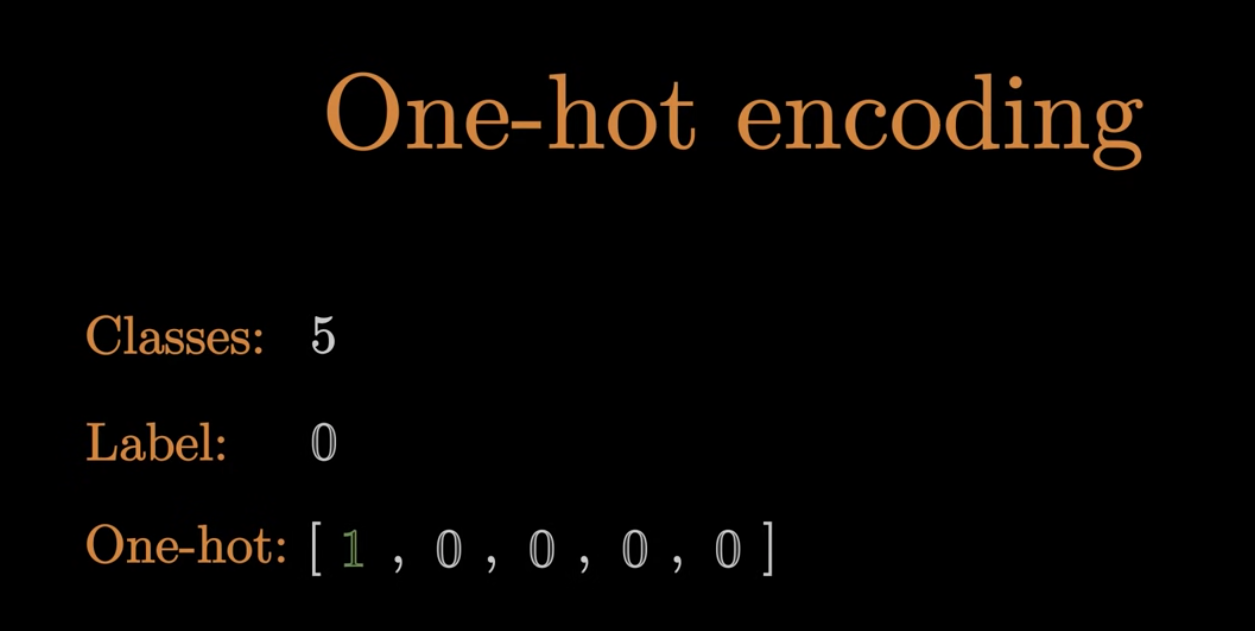

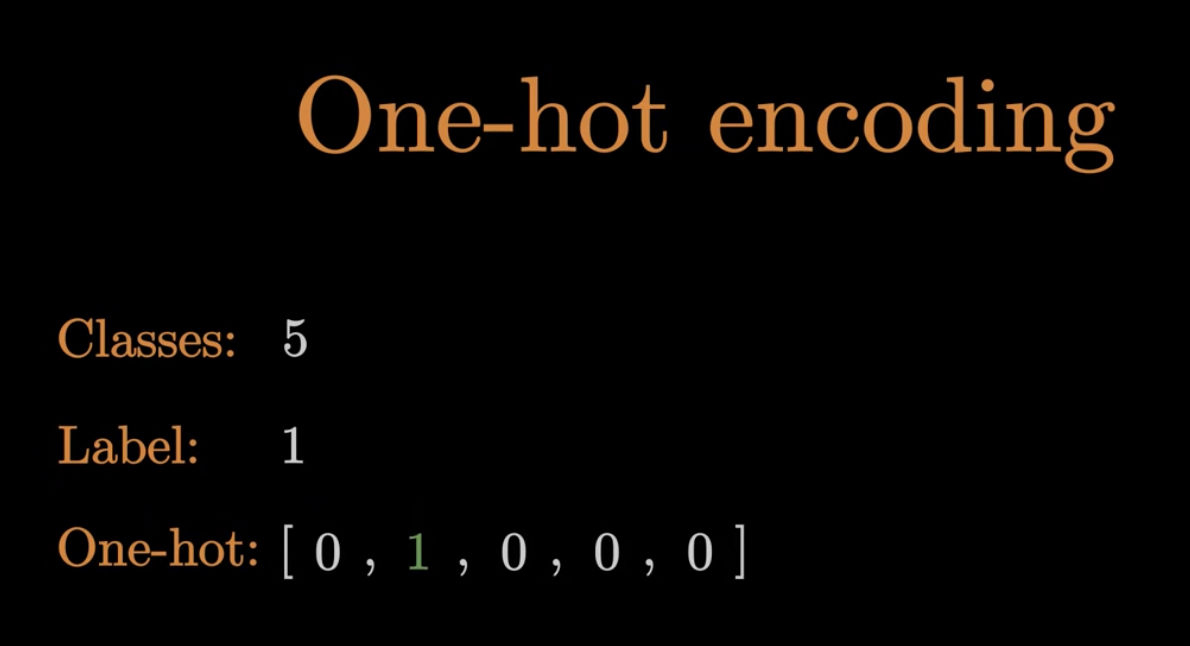

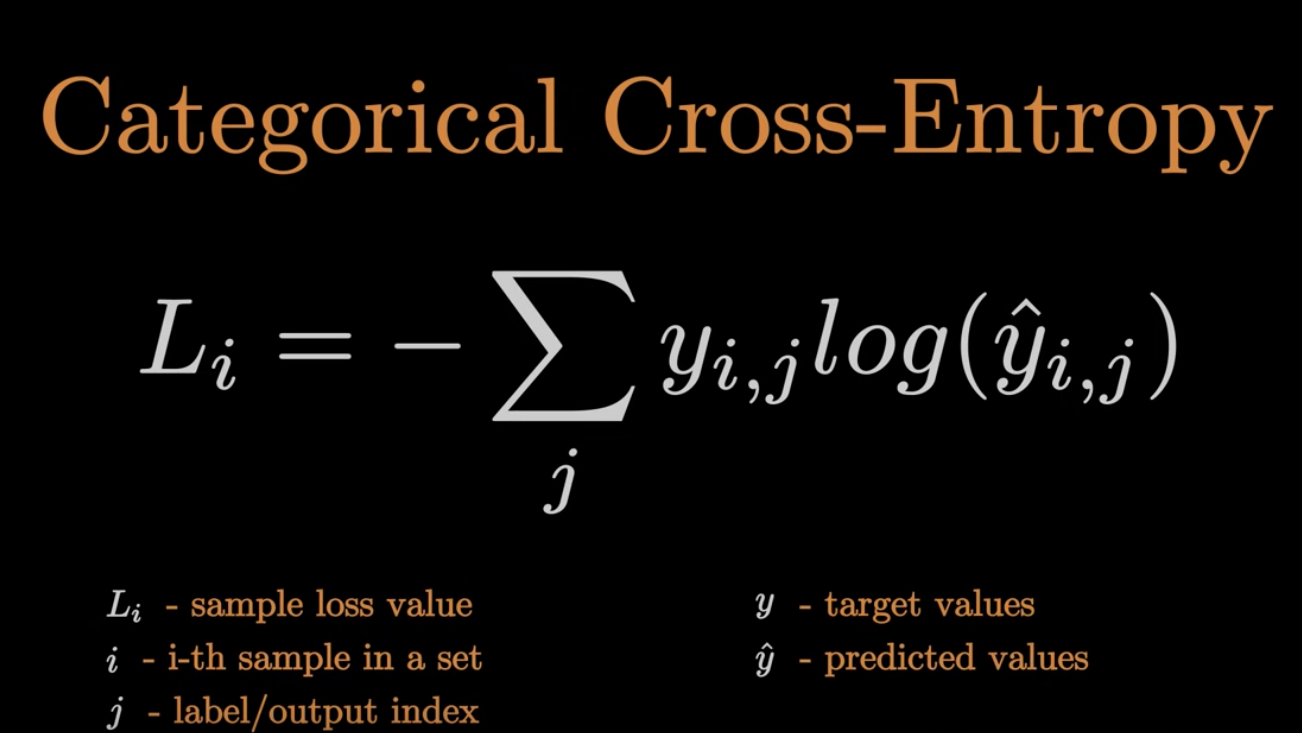

What is categorical cross entrophy

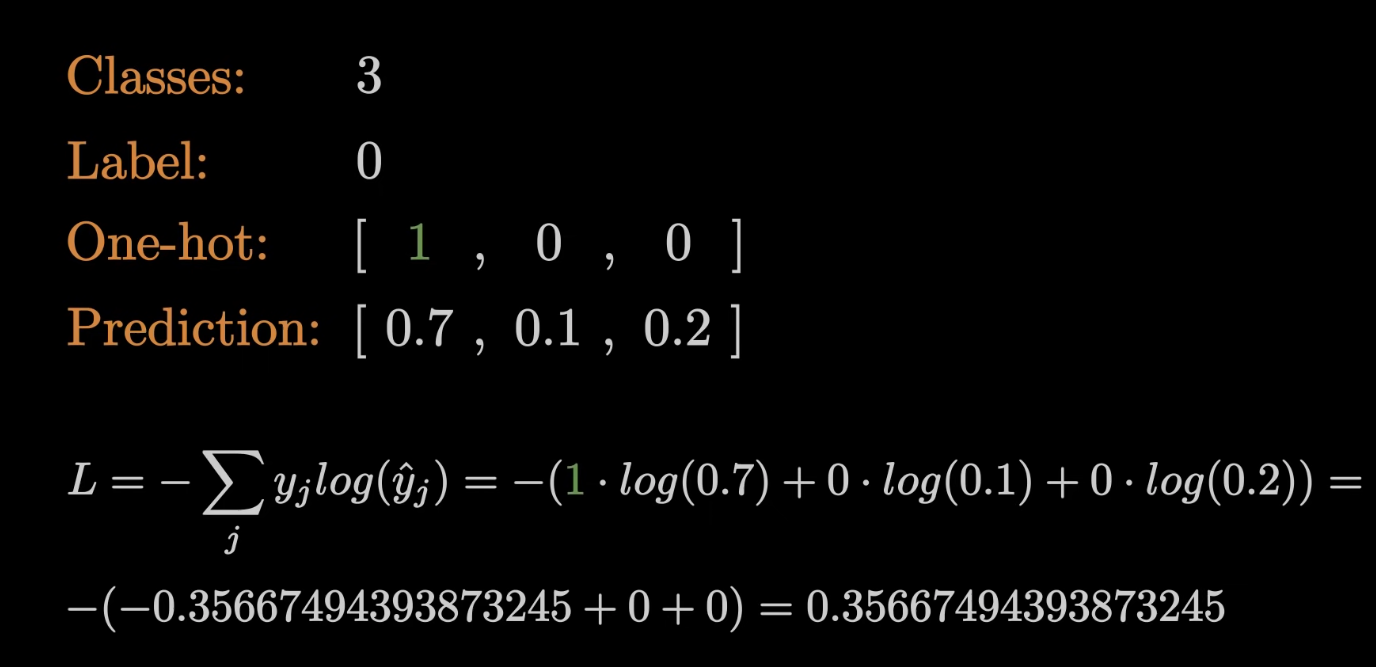

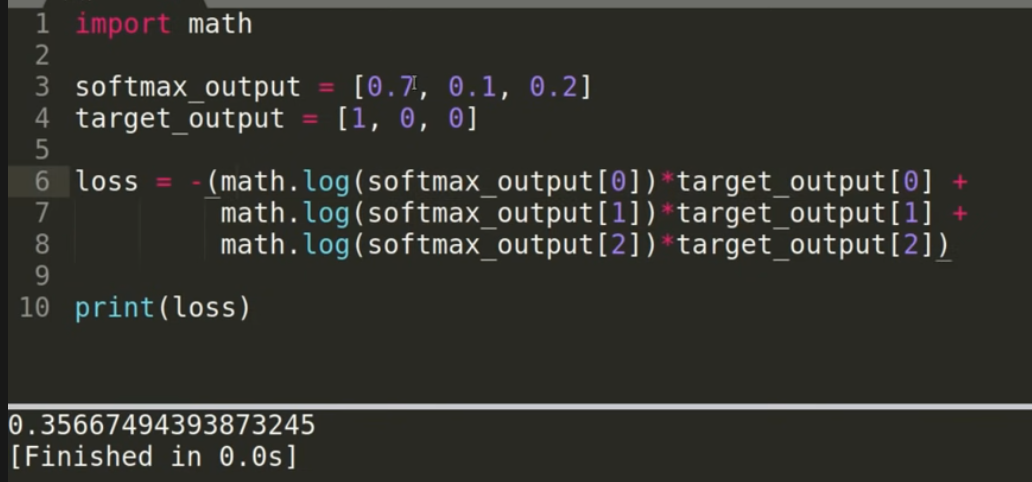

Loss vs Accuracy

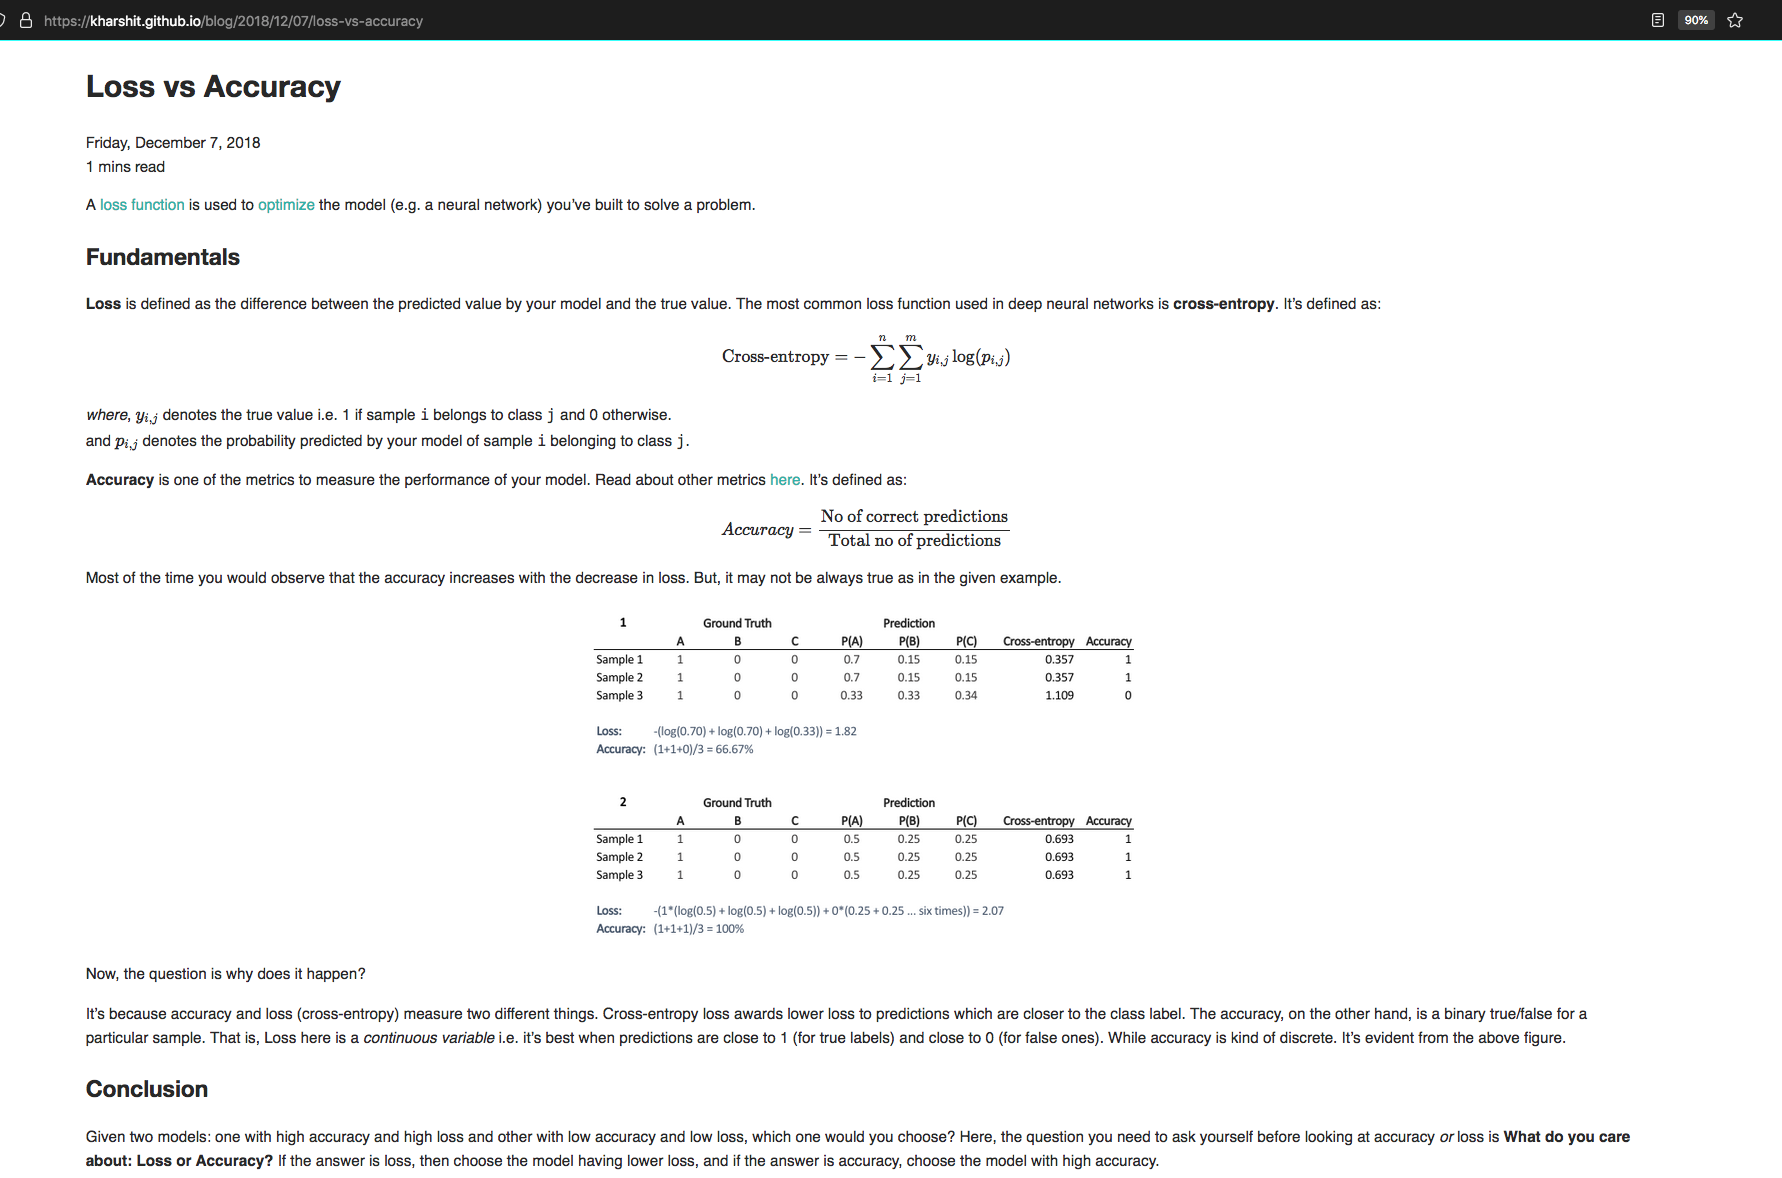

In [ ]:
# For multi-class: reference from
#https://stackoverflow.com/questions/35400065/multilabel-text-classification-using-tensorflow/39472895#39472895

# The labels must be one-hot encoded

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels = one_hot_y)
loss = tf.reduce_sum(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(loss)

predictions = tf.argmax(logits, axis=1, output_type=tf.int32, name='predictions')
accuracy = tf.reduce_sum(tf.cast(tf.equal(predictions, true_labels), tf.float32))

Another example

# LOSS AND OPTIMIZER
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08).minimize(loss, global_step=global_step)


# PREDICTION AND ACCURACY CALCULATION
correct_prediction = tf.equal(y_pred_cls, tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# 12 Model Training

In [ ]:
#loss function,optimizer and performance mesurment 
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(lr=1e-5,decay=1e-6)
acc=tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
model=classifier_model()

In [ ]:
model.compile(optimizer=optimizer,loss=loss,metrics=[acc])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

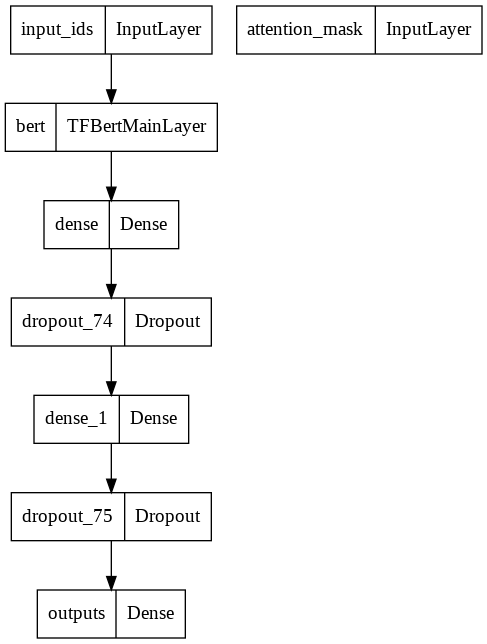

In [ ]:
tf.keras.utils.plot_model(model)


Possible solutions of Overfiting intext classifcation are try fine tune( train some layers only)the bert instead of training the whole BERT model,reduce learning rate. So to  use a pre-trained Transformer (such as BERT), you, of course, cannot change the model dimension. In that case, you can try to set a much smaller learning rate for fine-tuning BERT than you use for training the actual classifier. Broadly speaking, to reduce overfitting, you can:

    1. increase regularization
    2. reduce model complexity
    3. perform early stopping
    4. increase training data

  


In [ ]:
# batch_size=40
epoches=100

In [ ]:

history=model.fit(train_ds,validation_data=val_ds, epochs = epoches )

Epoch 1/100
2169/2169 [==============================] - 1874s 859ms/step - loss: 2.5501 - accuracy: 0.1674 - val_loss: 2.4632 - val_accuracy: 0.1733
Epoch 2/100
2169/2169 [==============================] - 1860s 858ms/step - loss: 1.8700 - accuracy: 0.3893 - val_loss: 2.3036 - val_accuracy: 0.2366
Epoch 3/100
2169/2169 [==============================] - 1860s 858ms/step - loss: 1.5243 - accuracy: 0.4899 - val_loss: 2.2762 - val_accuracy: 0.2498
Epoch 4/100
2169/2169 [==============================] - 1861s 858ms/step - loss: 1.2259 - accuracy: 0.5816 - val_loss: 2.3183 - val_accuracy: 0.2651
Epoch 5/100
2169/2169 [==============================] - 1861s 858ms/step - loss: 1.0029 - accuracy: 0.6568 - val_loss: 2.3973 - val_accuracy: 0.2783
Epoch 6/100
2169/2169 [==============================] - 1861s 858ms/step - loss: 0.7992 - accuracy: 0.7274 - val_loss: 2.5137 - val_accuracy: 0.2915
Epoch 7/100
2169/2169 [==============================] - 1860s 858ms/step - loss: 0.6254 - accuracy:

# 13 outputs

freezlayer 2, augment and balance chop 512 below

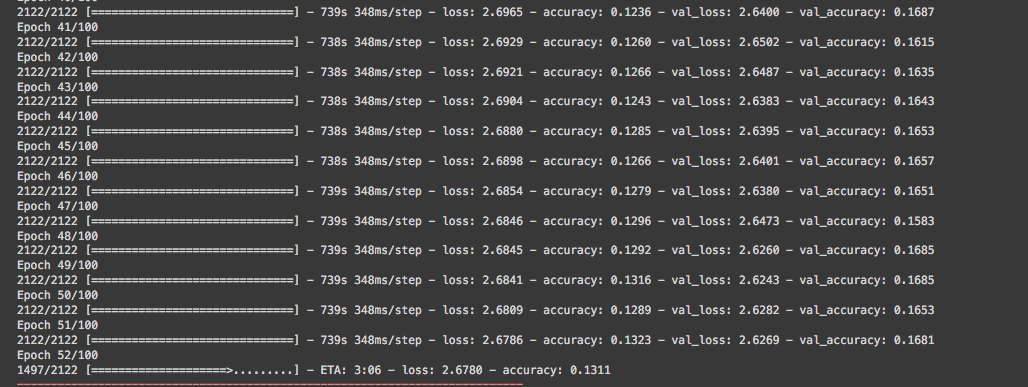

choped to 512, unbalanced 50 epoch below

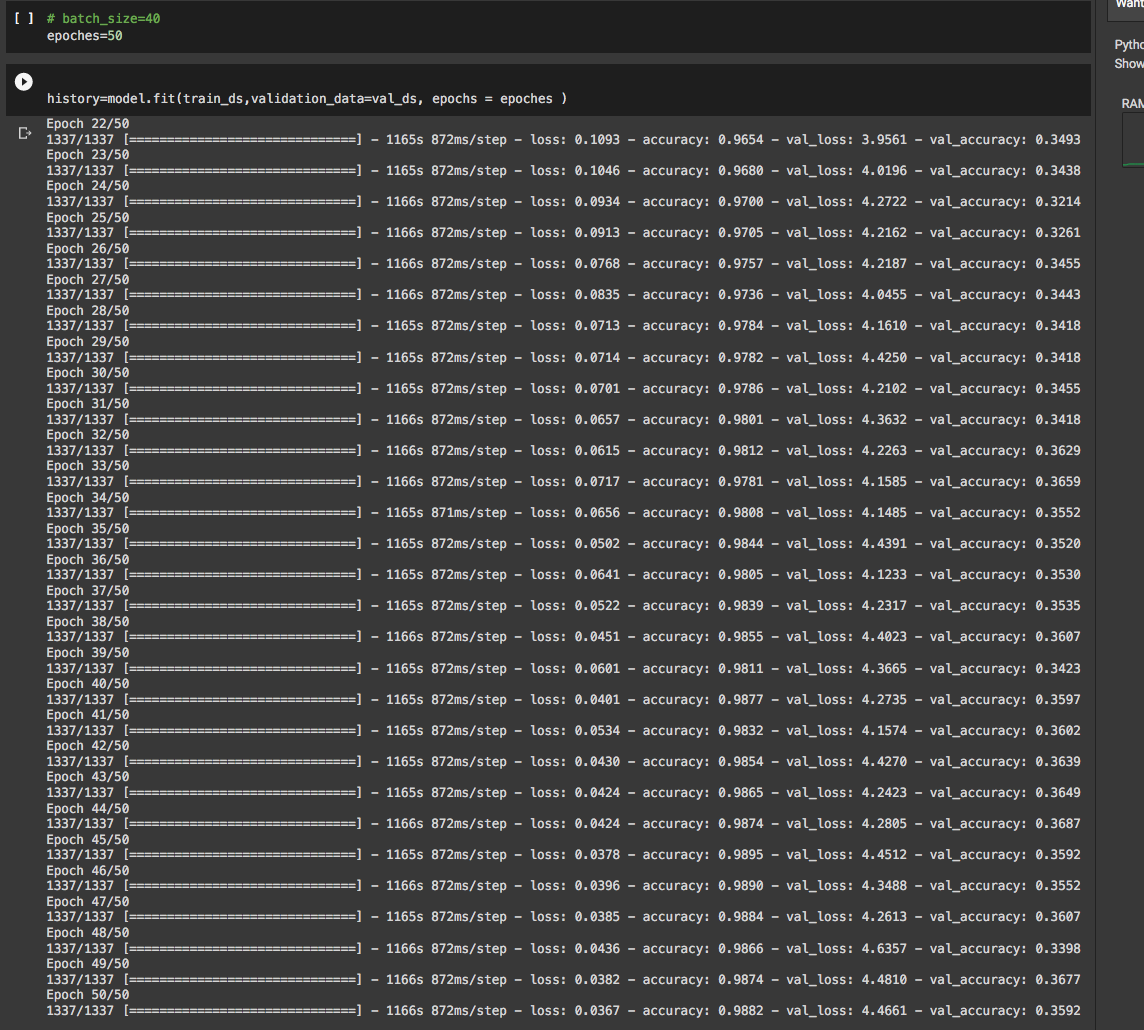

Below choped 512 unbalanced two dropout for epoch 20 

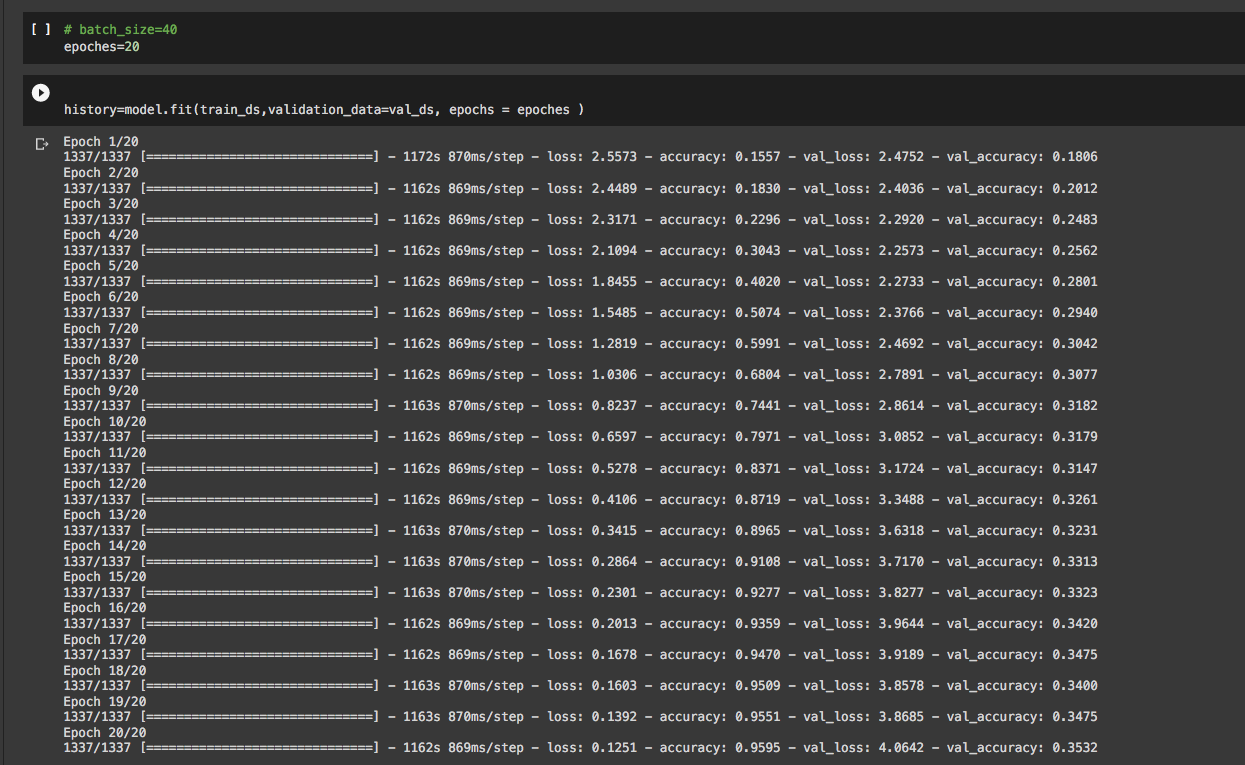

choped-512 and unbalanced tweets for epoch 20 result below

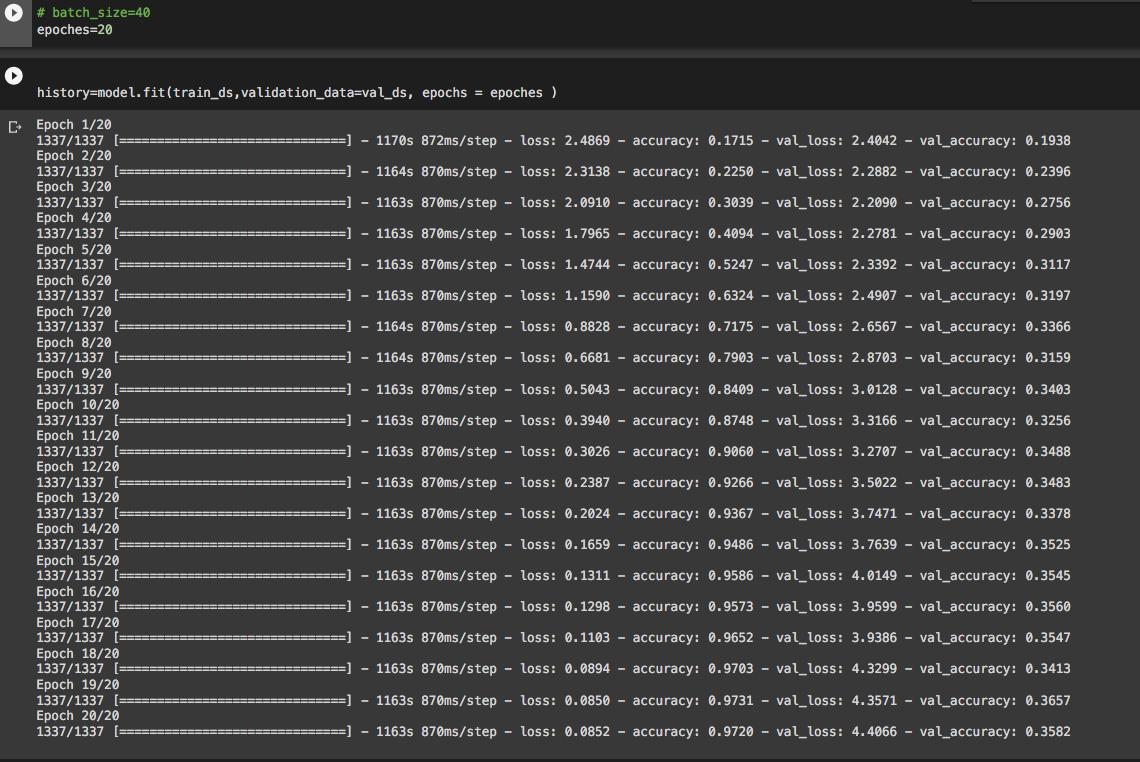

# 14 save dic and model

In [ ]:
# save model 
model.save('/content/drive/MyDrive/datasets/twitter_personality_dataset/classifier_model_balanced.h5',overwrite=True,include_optimizer=True)

In [ ]:
#load saved model
model_loaded=tf.keras.models.load_model('/content/drive/MyDrive/datasets/twitter_personality_dataset/classifier_model_balanced.h5')
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

# 15 Evaluation

In [ ]:
loss,accuracy=model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


27/27 [==============================] - 7s 260ms/step - loss: 2.0150 - accuracy: 0.3858
Loss: 2.0149614810943604
Accuracy: 0.3858024775981903


In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


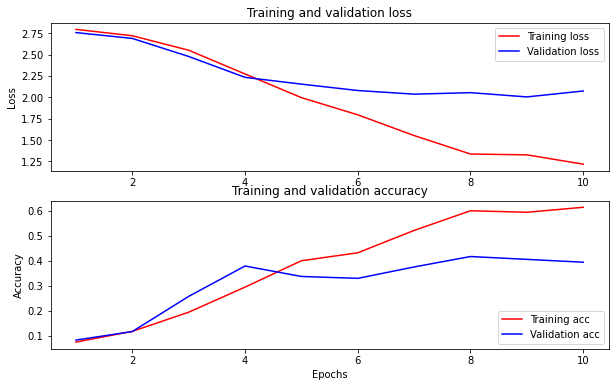

In [ ]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


# 16 Evaluation output

balanced_100_10

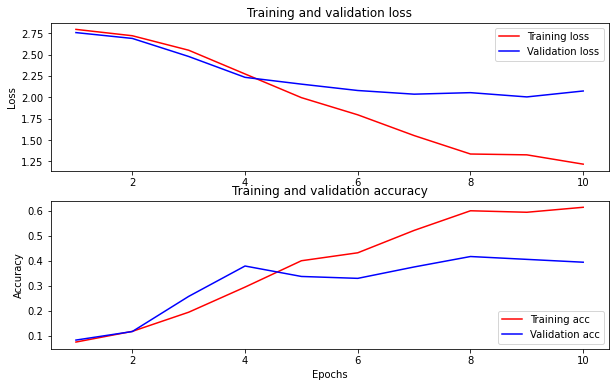

# 17 Additional Note

In [ ]:
# test_predictions = model.predict(x=[test_input_ids, 
#                                     test_input_masks, 
#                                     test_segment_ids],
#                                  batch_size=100,
#                                  verbose=1)
test_predictions = model.predict(x=[test_ds,
                                 batch_size=100,
                                 verbose=1)

In [ ]:
test_predictions = test_predictions.ravel()

In [ ]:
test_pred_labels = [1 if prob > 0.5 else 0 for prob in test_predictions]

In [ ]:
# test_labels = test_df['sentiment'].tolist()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('Classification Report:')
print(classification_report(y_true=test_labels, y_pred=test_pred_labels))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

with tf.Session() as session:
    cm = tf.confusion_matrix(test_labels, test_pred_labels).eval()

LABELS = ['negative', 'positive']
sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='g')
xl = plt.xlabel("Predicted")
yl = plt.ylabel("Actuals")

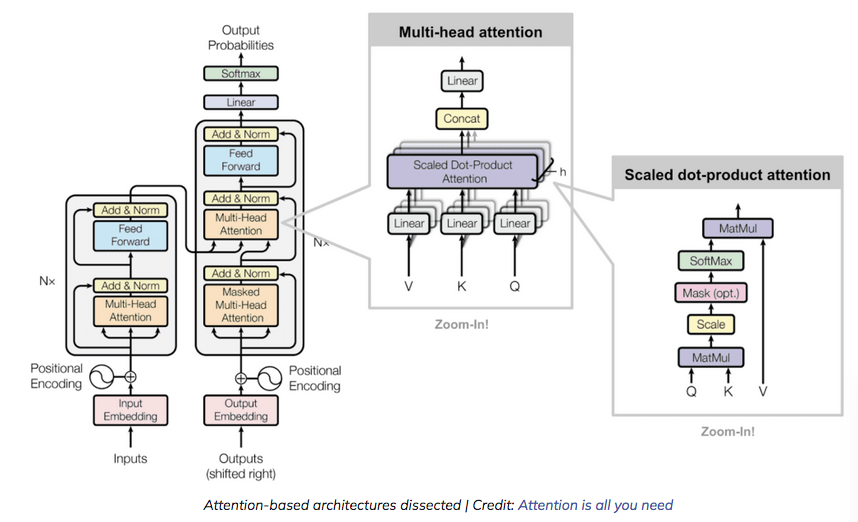

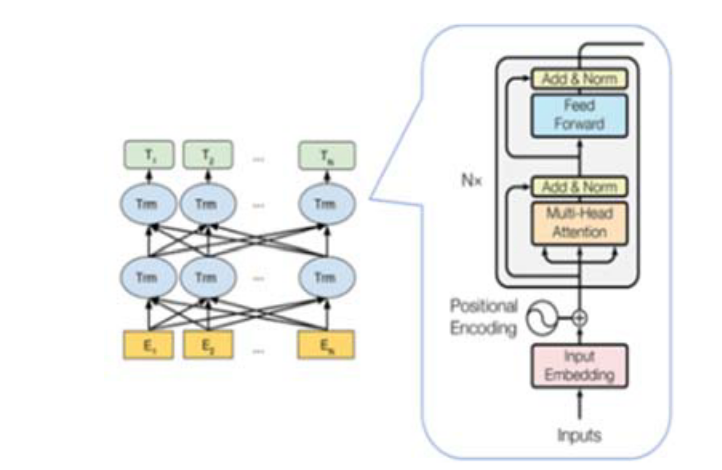

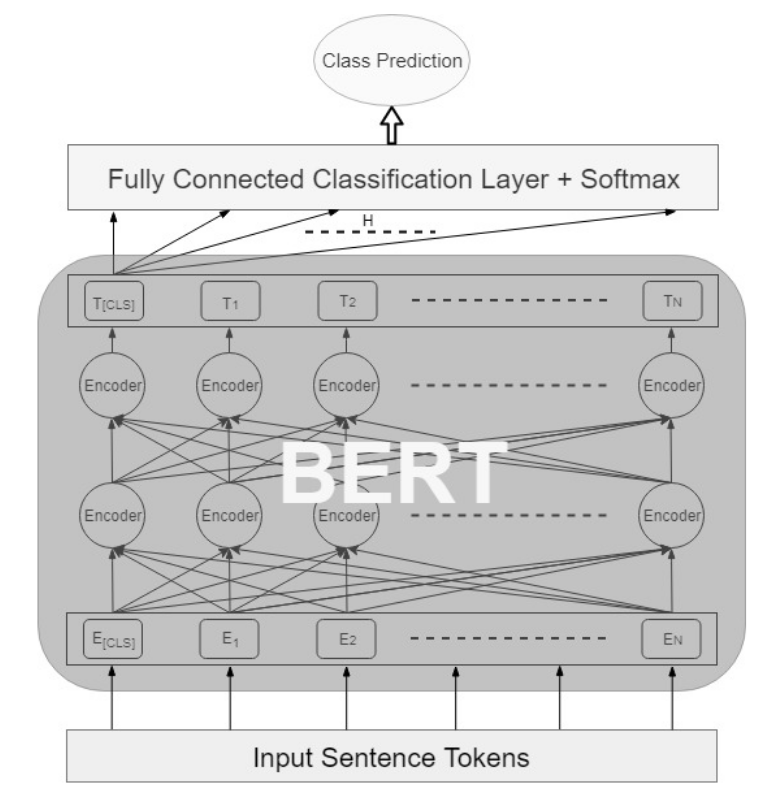

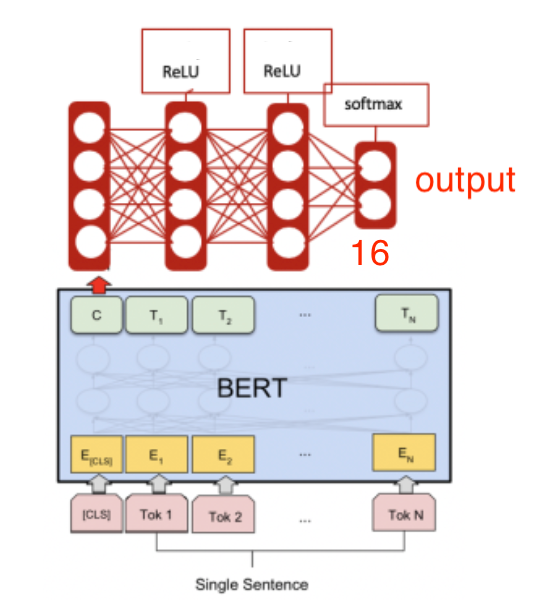